https://www.bgc-jena.mpg.de/wetter/

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model 

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [6]:
# feature selection
data_selected = data.iloc[:, [0,1,4,8,16,20]]
display(data_selected.head())

,p (mbar),T (degC),rh (%),sh (g/kg),SWDR (W/m²),CO2 (ppm)
Date Time,,,,,,
01.07.2022 00:10:00,984.33,22.42,84.7,14.67,0.0,447.2
01.07.2022 00:20:00,984.36,22.02,86.8,14.67,0.0,445.6
01.07.2022 00:30:00,984.35,21.77,87.9,14.63,0.0,443.1
01.07.2022 00:40:00,984.27,22.00,85.6,14.45,0.0,443.4
01.07.2022 00:50:00,984.36,22.23,84.0,14.38,0.0,444.4


In [7]:
col_names = list(data_selected.columns)
colors = ['b','g','r','c','m','y']

In [8]:
# for i in range(data_selected.shape[1]):
#     plt.figure(figsize=(15,6))
#     plt.plot(data_selected.iloc[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data_selected)


In [10]:
# train and test split
test_size = 1008
train = data_scaled[:-test_size,:]
test = data_scaled[-test_size:,:]


In [11]:
print(train.size)
print(test.size)

185532
6048


In [12]:
def plot_histogram(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])

    plt.show()

In [13]:
def plot_boxplot(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])

    plt.show()

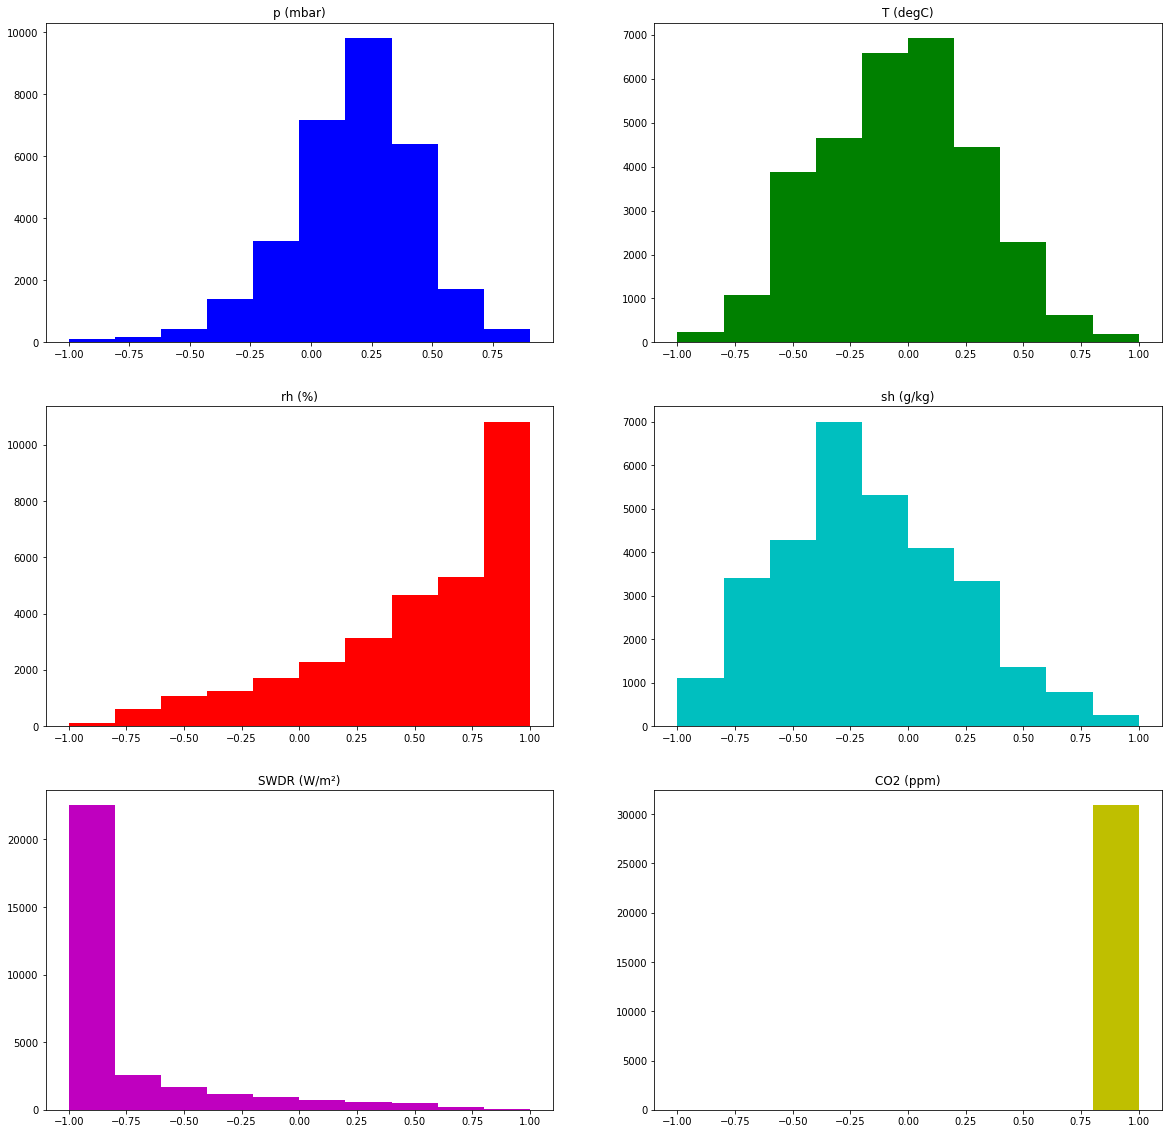

In [14]:
plot_histogram(3,2,train,col_names,colors)

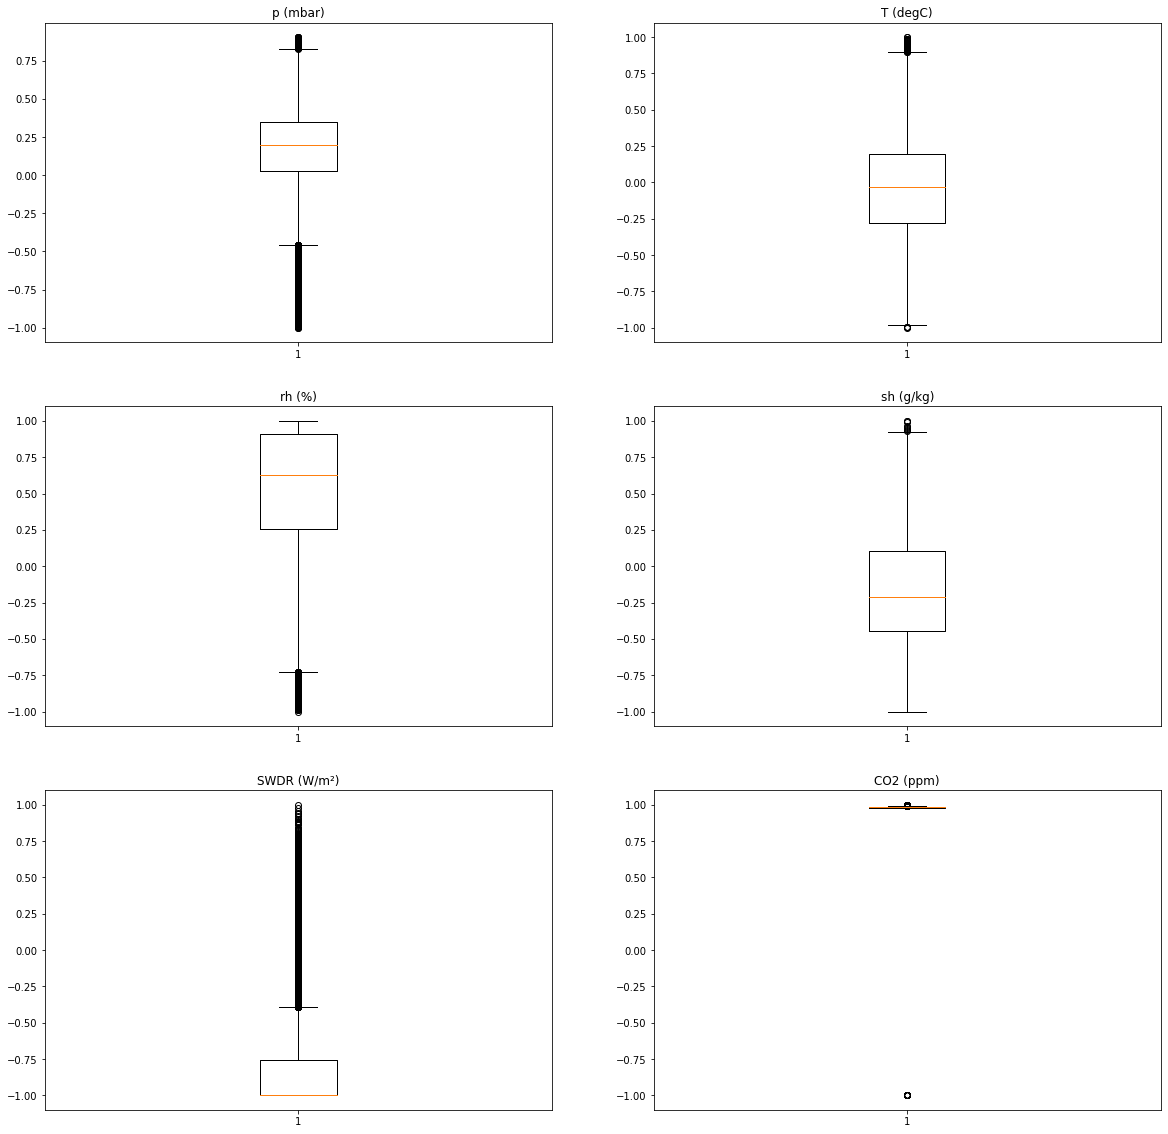

In [15]:
plot_boxplot(3,2,train,col_names,colors)

In [16]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-100,anomaly_idx_list[i]+101):
            if(train.shape[0]-101>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        if size != 0:
            train[anomaly_idx_list[i],index] = mean/size
    return train

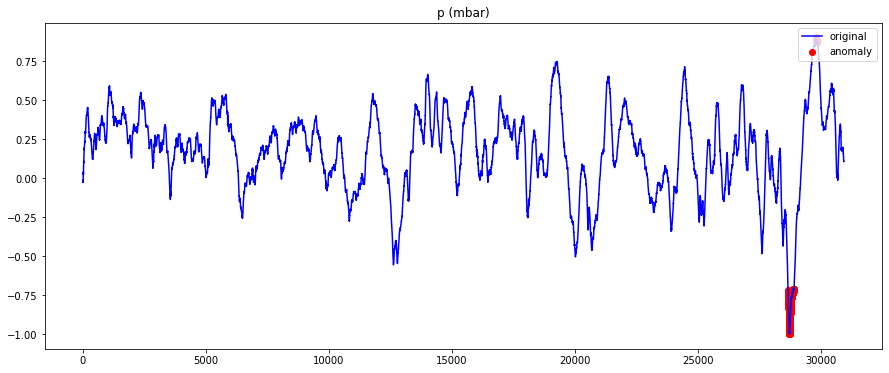

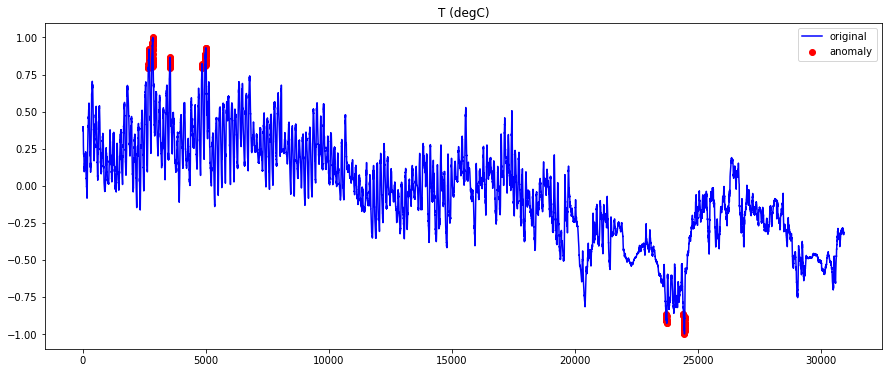

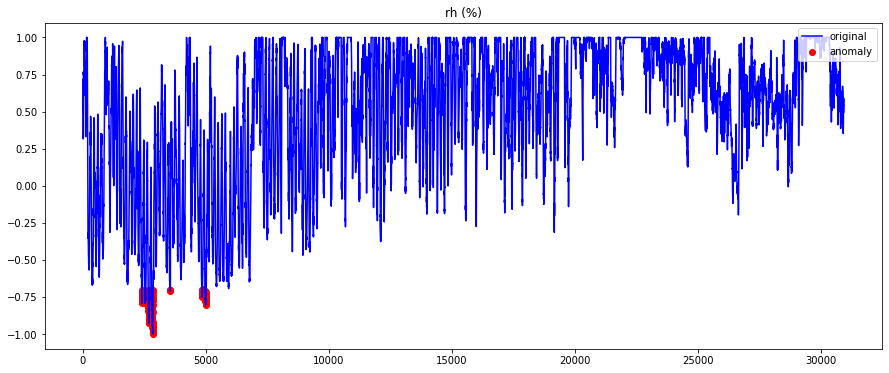

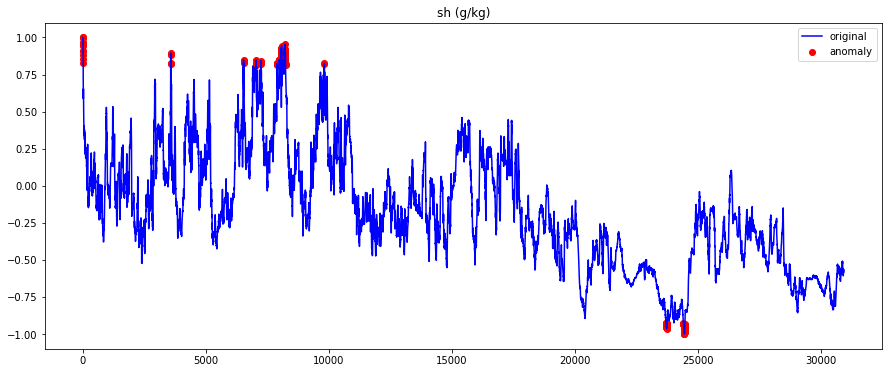

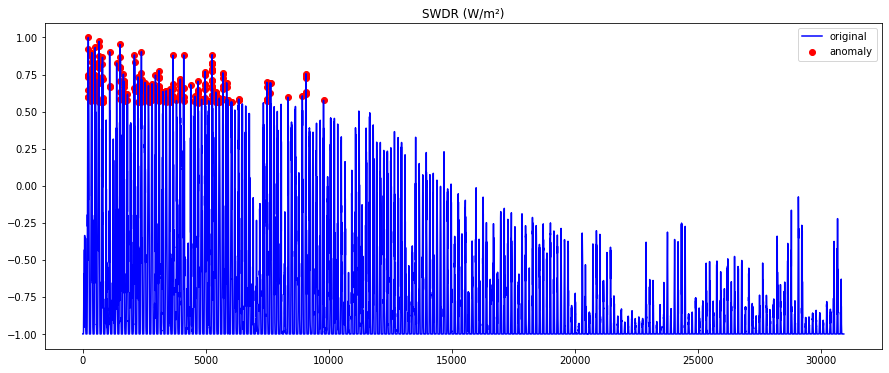

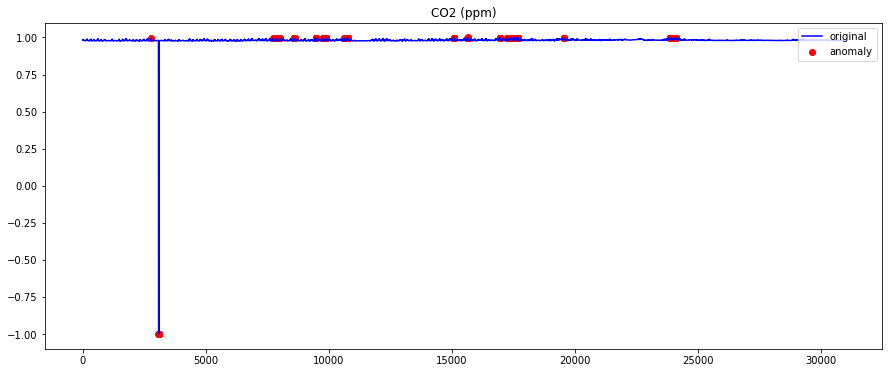

In [17]:
isolation_forest = IsolationForest(contamination=0.01)

for idx in range(train.shape[1]):
    dt_feature = [[item] for item in train[:,idx]]
    isolation_forest.fit(dt_feature)
    pred = isolation_forest.predict(dt_feature)
    anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
    train = remove_anomaly(train,idx,anomaly)
    
    anomaly_val = []
    for i in range(len(anomaly)):
        anomaly_val.append(dt_feature[anomaly[i]])
    plt.plot(dt_feature,color='b')
    plt.title(col_names[idx])
    plt.scatter(anomaly,anomaly_val,color='r')
    plt.legend(['original','anomaly'], loc='upper right')
    plt.show()



In [18]:
# def remove_anomaly(train,index,min_boundary=-1,max_boundary=1):
#     remove_row = []
#     mean = np.mean(train[:,index])
#     for i in range(train.shape[0]):
#         if (min_boundary>train[i,index] or max_boundary<train[i,index]):
#             train[i,index] = mean
# #             if train.shape[0]-1>i>0:
# #                 train[i,index] = (train[i,index]+train[i-1,index] + train[i+1,index])/3
                
#             remove_row = np.append(remove_row,i)
# #     if remove_row!=[]:
# #         remove_row = remove_row.astype(int)
#         # delete
#         # train = np.delete(train, remove_row,axis=0)
#         # correct
#     print(len(remove_row))
#     return train

In [19]:
# # remove anomalies
# train = remove_anomaly(train,5,min_boundary=0.95,max_boundary=0.9921) # CO2
# # print(train_wo_anomaly)
# train = remove_anomaly(train,4,max_boundary=0.778)
# # print(train)

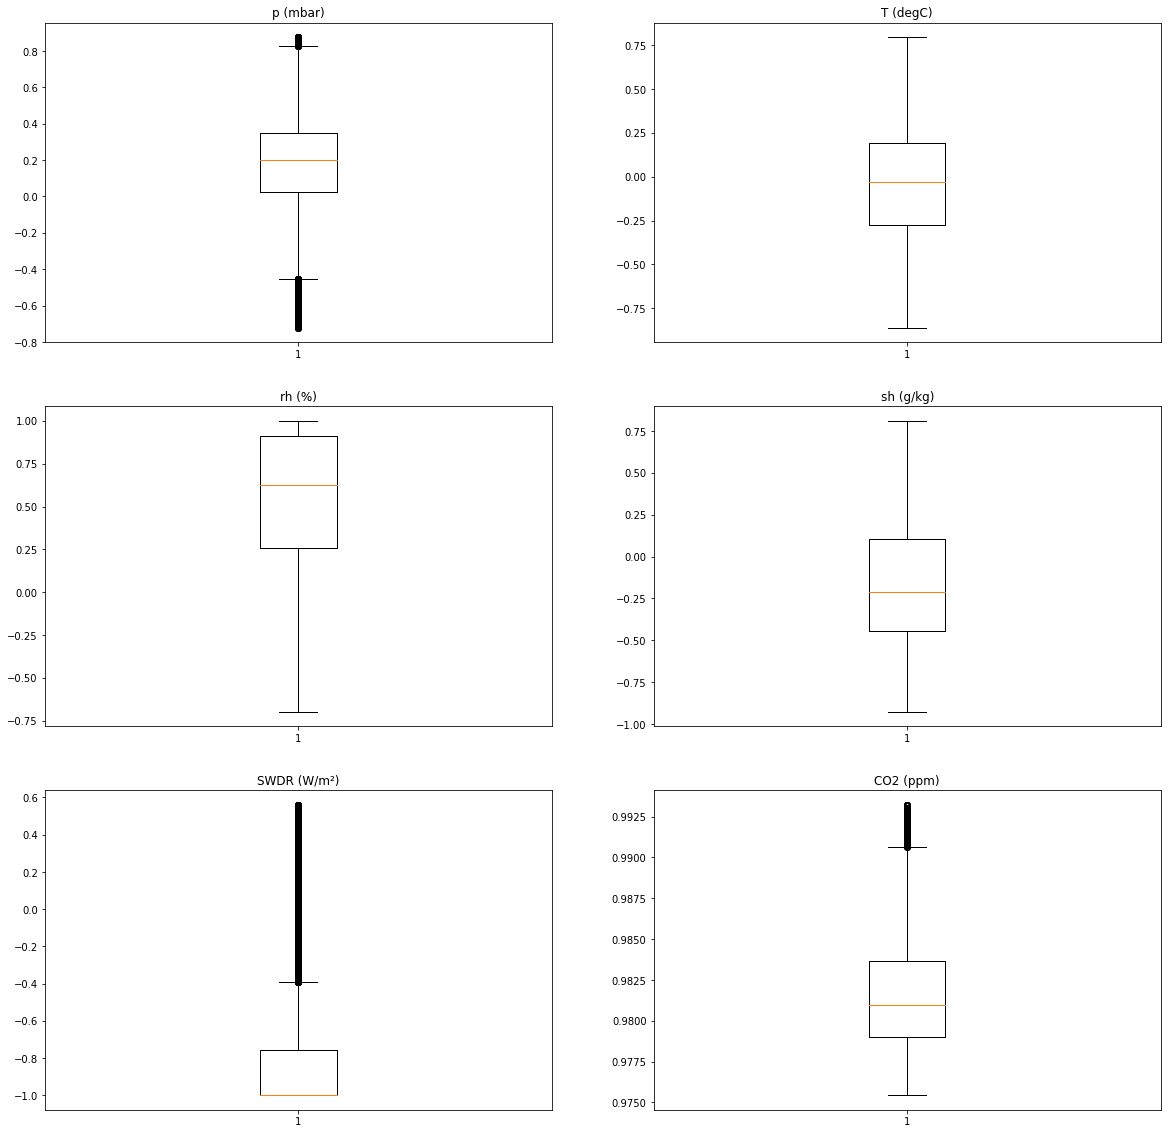

In [20]:
# print(train)
plot_boxplot(3,2,train,col_names,colors)

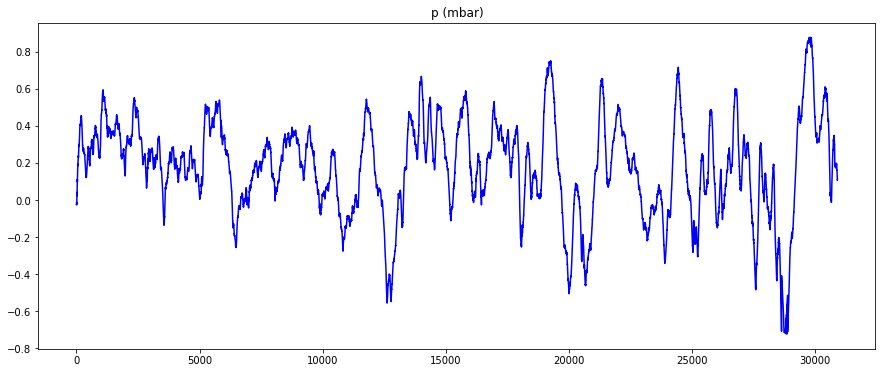

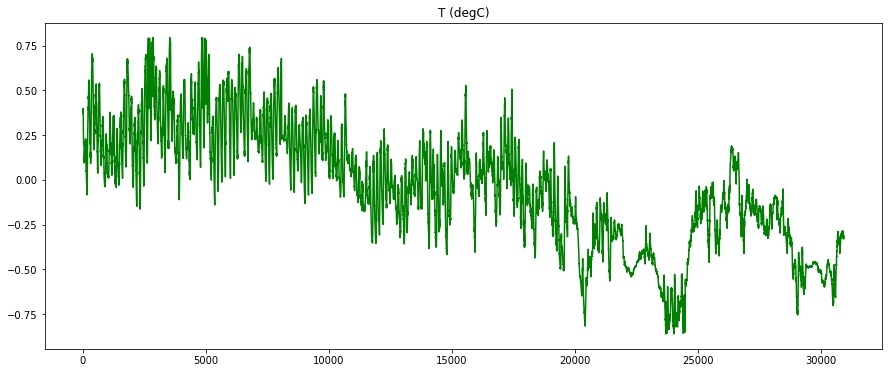

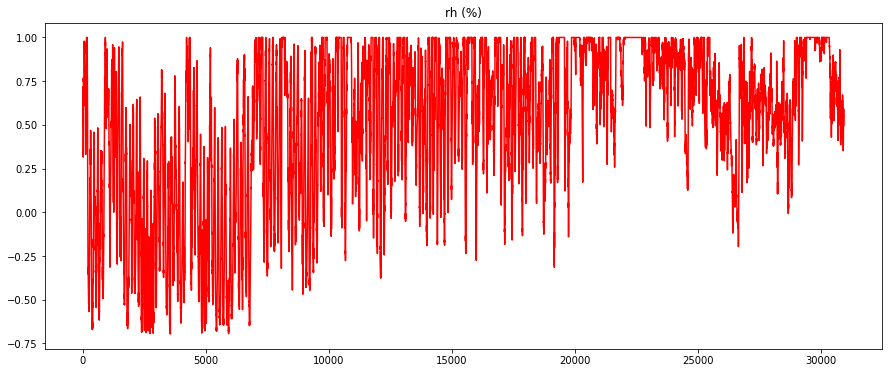

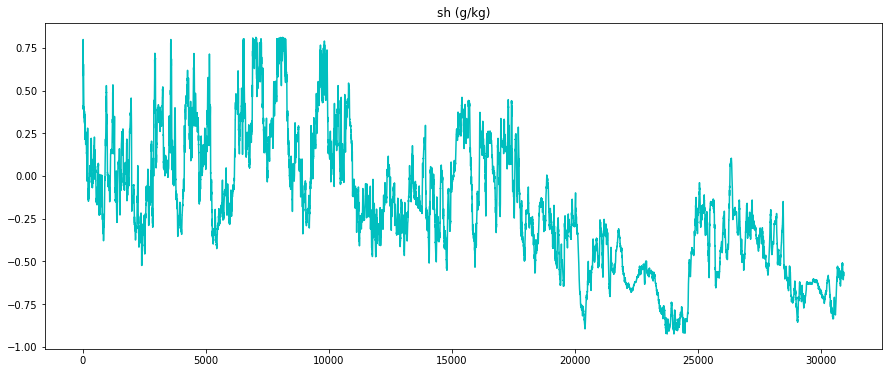

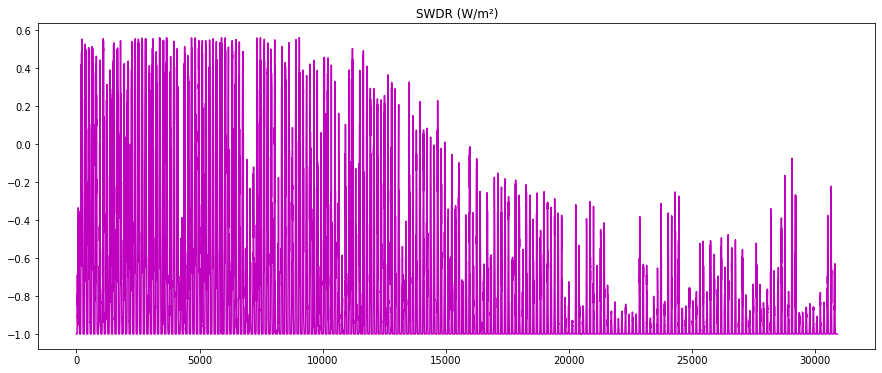

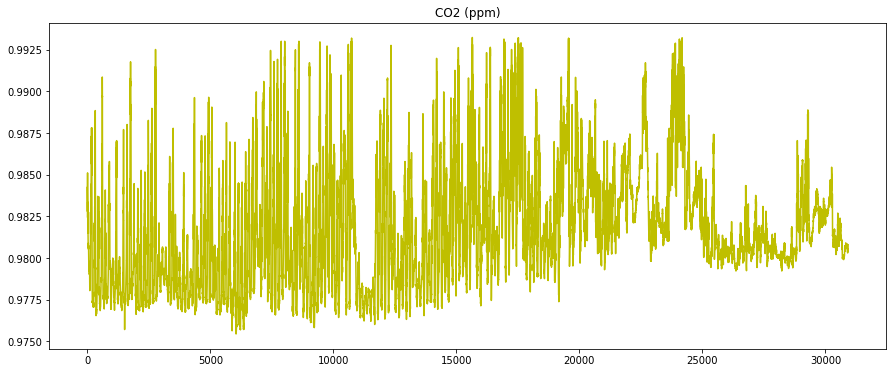

In [21]:
for i in range(train.shape[1]):
    plt.plot(train[:,i],color=colors[i])
    plt.title(col_names[i])
    plt.show()


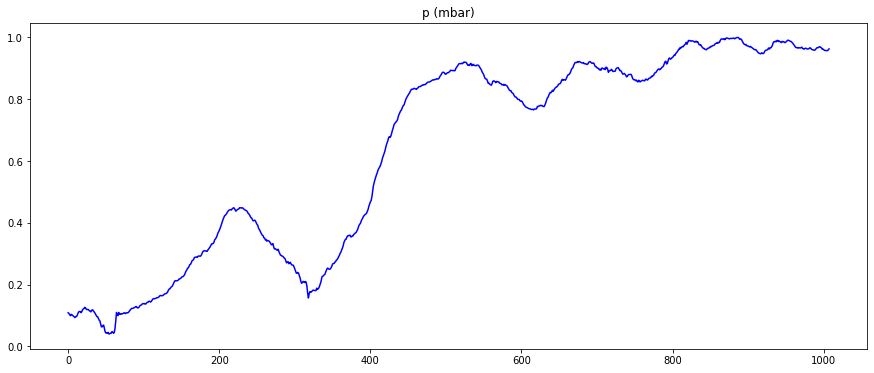

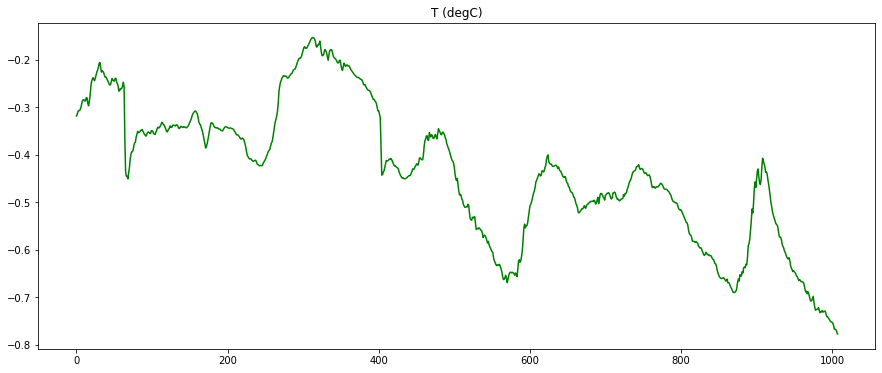

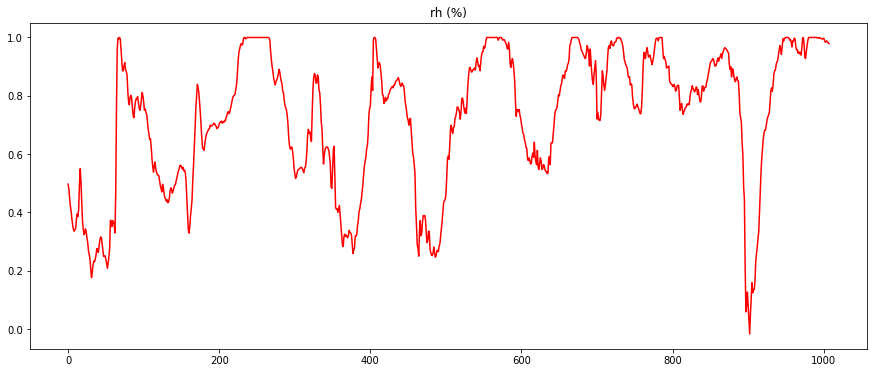

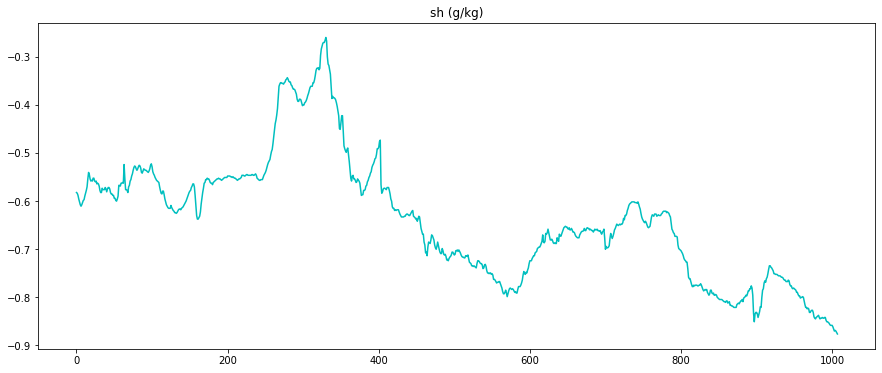

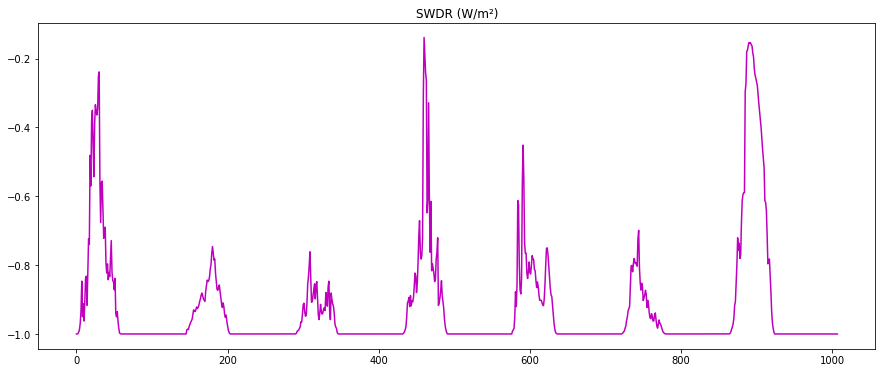

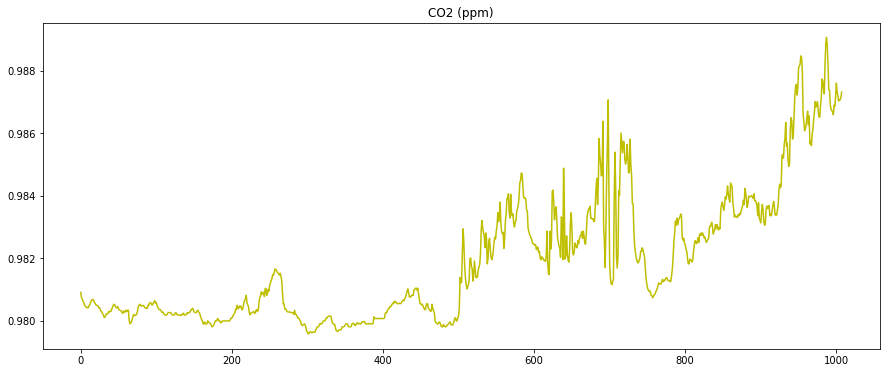

In [22]:
for i in range(test.shape[1]):
    plt.plot(test[:,i],color=colors[i])
    plt.title(col_names[i])
    plt.show()

In [23]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [24]:
n_features = 6
n_months_in = 103
n_months_out = 31
X_train, y_train = split_sequences(train,n_months_in,n_months_out)
X_test, y_test = split_sequences(test,n_months_in,n_months_out)

In [25]:
# print(train[0:n_months_in+n_months_out,:])
# print("---------------------------------------------------------------")
# print(X_train[0:1,:])
# print("---------------------------------------------------------------")
# print(y_test[0:1,:])
# print("---------------------------------------------------------------")
print(train.shape)
print(test.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30922, 6)
(1008, 6)
(994, 103, 6) (994, 31, 6)
(29, 103, 6) (29, 31, 6)


In [26]:
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(994, 186)
(29, 186)


In [27]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=False,recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_months_out*n_features))


In [28]:
# 
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
epochs = 3000
validation_split = 0.3 # 30% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs,  verbose=1,validation_split=validation_split,shuffle=False)

Epoch 1/3000
22/22 [==============================] - 9s 170ms/step - loss: 0.3925 - val_loss: 0.5152
Epoch 2/3000
22/22 [==============================] - 3s 128ms/step - loss: 0.3908 - val_loss: 0.5133
Epoch 3/3000
22/22 [==============================] - 3s 130ms/step - loss: 0.3892 - val_loss: 0.5114
Epoch 4/3000
22/22 [==============================] - 3s 126ms/step - loss: 0.3875 - val_loss: 0.5095
Epoch 5/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.3859 - val_loss: 0.5076
Epoch 6/3000
22/22 [==============================] - 3s 128ms/step - loss: 0.3843 - val_loss: 0.5058
Epoch 7/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.3826 - val_loss: 0.5039
Epoch 8/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.3810 - val_loss: 0.5018
Epoch 9/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.3791 - val_loss: 0.4988
Epoch 10/3000
22/22 [==============================] - 3s 133ms/step - loss: 0.376

22/22 [==============================] - 3s 123ms/step - loss: 0.0466 - val_loss: 0.0195
Epoch 81/3000
22/22 [==============================] - 3s 139ms/step - loss: 0.0468 - val_loss: 0.0193
Epoch 82/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0458 - val_loss: 0.0193
Epoch 83/3000
22/22 [==============================] - 3s 126ms/step - loss: 0.0458 - val_loss: 0.0188
Epoch 84/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0450 - val_loss: 0.0185
Epoch 85/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0446 - val_loss: 0.0187
Epoch 86/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0446 - val_loss: 0.0182
Epoch 87/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0441 - val_loss: 0.0183
Epoch 88/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0429 - val_loss: 0.0183
Epoch 89/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0429 - v

22/22 [==============================] - 3s 116ms/step - loss: 0.0304 - val_loss: 0.0138
Epoch 160/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0299 - val_loss: 0.0139
Epoch 161/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0302 - val_loss: 0.0135
Epoch 162/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0307 - val_loss: 0.0137
Epoch 163/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0304 - val_loss: 0.0157
Epoch 164/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0300 - val_loss: 0.0161
Epoch 165/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0289 - val_loss: 0.0152
Epoch 166/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0292 - val_loss: 0.0145
Epoch 167/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0288 - val_loss: 0.0137
Epoch 168/3000
22/22 [==============================] - 2s 108ms/step - loss: 0

Epoch 238/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0261 - val_loss: 0.0140
Epoch 239/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0250 - val_loss: 0.0137
Epoch 240/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0251 - val_loss: 0.0132
Epoch 241/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0249 - val_loss: 0.0126
Epoch 242/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0245 - val_loss: 0.0124
Epoch 243/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0257 - val_loss: 0.0124
Epoch 244/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0253 - val_loss: 0.0145
Epoch 245/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0249 - val_loss: 0.0131
Epoch 246/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0251 - val_loss: 0.0123
Epoch 247/3000
22/22 [==============================] - 3s 122ms

Epoch 317/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0228 - val_loss: 0.0125
Epoch 318/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0223 - val_loss: 0.0129
Epoch 319/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0222 - val_loss: 0.0117
Epoch 320/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0222 - val_loss: 0.0121
Epoch 321/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0225 - val_loss: 0.0129
Epoch 322/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0224 - val_loss: 0.0144
Epoch 323/3000
22/22 [==============================] - 3s 157ms/step - loss: 0.0221 - val_loss: 0.0131
Epoch 324/3000
22/22 [==============================] - 3s 156ms/step - loss: 0.0226 - val_loss: 0.0125
Epoch 325/3000
22/22 [==============================] - 3s 160ms/step - loss: 0.0217 - val_loss: 0.0129
Epoch 326/3000
22/22 [==============================] - 4s 161ms

Epoch 396/3000
22/22 [==============================] - 4s 160ms/step - loss: 0.0205 - val_loss: 0.0120
Epoch 397/3000
22/22 [==============================] - 3s 159ms/step - loss: 0.0208 - val_loss: 0.0106
Epoch 398/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0206 - val_loss: 0.0126
Epoch 399/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0206 - val_loss: 0.0137
Epoch 400/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0202 - val_loss: 0.0113
Epoch 401/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0204 - val_loss: 0.0133
Epoch 402/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0206 - val_loss: 0.0112
Epoch 403/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0202 - val_loss: 0.0131
Epoch 404/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0205 - val_loss: 0.0126
Epoch 405/3000
22/22 [==============================] - 3s 149ms

Epoch 475/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0185 - val_loss: 0.0127
Epoch 476/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0188 - val_loss: 0.0117
Epoch 477/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0185 - val_loss: 0.0119
Epoch 478/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0189 - val_loss: 0.0122
Epoch 479/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0182 - val_loss: 0.0110
Epoch 480/3000
22/22 [==============================] - 3s 149ms/step - loss: 0.0182 - val_loss: 0.0117
Epoch 481/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0186 - val_loss: 0.0130
Epoch 482/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0183 - val_loss: 0.0110
Epoch 483/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0190 - val_loss: 0.0129
Epoch 484/3000
22/22 [==============================] - 3s 151ms

Epoch 554/3000
22/22 [==============================] - 3s 154ms/step - loss: 0.0173 - val_loss: 0.0127
Epoch 555/3000
22/22 [==============================] - 3s 154ms/step - loss: 0.0179 - val_loss: 0.0129
Epoch 556/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0175 - val_loss: 0.0121
Epoch 557/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0171 - val_loss: 0.0120
Epoch 558/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0177 - val_loss: 0.0111
Epoch 559/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0173 - val_loss: 0.0125
Epoch 560/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0177 - val_loss: 0.0131
Epoch 561/3000
22/22 [==============================] - 3s 152ms/step - loss: 0.0178 - val_loss: 0.0111
Epoch 562/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0175 - val_loss: 0.0114
Epoch 563/3000
22/22 [==============================] - 3s 153ms

Epoch 633/3000
22/22 [==============================] - 3s 155ms/step - loss: 0.0164 - val_loss: 0.0102
Epoch 634/3000
22/22 [==============================] - 3s 155ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 635/3000
22/22 [==============================] - 3s 155ms/step - loss: 0.0166 - val_loss: 0.0120
Epoch 636/3000
22/22 [==============================] - 3s 153ms/step - loss: 0.0163 - val_loss: 0.0115
Epoch 637/3000
22/22 [==============================] - 3s 154ms/step - loss: 0.0170 - val_loss: 0.0101
Epoch 638/3000
22/22 [==============================] - 3s 154ms/step - loss: 0.0172 - val_loss: 0.0109
Epoch 639/3000
22/22 [==============================] - 3s 155ms/step - loss: 0.0173 - val_loss: 0.0138
Epoch 640/3000
22/22 [==============================] - 3s 154ms/step - loss: 0.0164 - val_loss: 0.0126
Epoch 641/3000
22/22 [==============================] - 3s 155ms/step - loss: 0.0163 - val_loss: 0.0106
Epoch 642/3000
22/22 [==============================] - 3s 155ms

Epoch 712/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 713/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0151 - val_loss: 0.0115
Epoch 714/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0155 - val_loss: 0.0104
Epoch 715/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0158 - val_loss: 0.0120
Epoch 716/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0156 - val_loss: 0.0105
Epoch 717/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0156 - val_loss: 0.0120
Epoch 718/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0157 - val_loss: 0.0099
Epoch 719/3000
22/22 [==============================] - 3s 149ms/step - loss: 0.0156 - val_loss: 0.0119
Epoch 720/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0156 - val_loss: 0.0108
Epoch 721/3000
22/22 [==============================] - 3s 148ms

Epoch 791/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0148 - val_loss: 0.0105
Epoch 792/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 793/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0150 - val_loss: 0.0114
Epoch 794/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0144 - val_loss: 0.0117
Epoch 795/3000
22/22 [==============================] - 3s 149ms/step - loss: 0.0146 - val_loss: 0.0111
Epoch 796/3000
22/22 [==============================] - 3s 151ms/step - loss: 0.0146 - val_loss: 0.0103
Epoch 797/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 798/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0146 - val_loss: 0.0101
Epoch 799/3000
22/22 [==============================] - 3s 150ms/step - loss: 0.0144 - val_loss: 0.0109
Epoch 800/3000
22/22 [==============================] - 3s 151ms

Epoch 870/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 871/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0143 - val_loss: 0.0097
Epoch 872/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 873/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0136 - val_loss: 0.0109
Epoch 874/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0139 - val_loss: 0.0111
Epoch 875/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0140 - val_loss: 0.0115
Epoch 876/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0142 - val_loss: 0.0110
Epoch 877/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 878/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 879/3000
22/22 [==============================] - 3s 119ms

Epoch 949/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0135 - val_loss: 0.0114
Epoch 950/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 951/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 952/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 953/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0130 - val_loss: 0.0133
Epoch 954/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0133 - val_loss: 0.0100
Epoch 955/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0134 - val_loss: 0.0117
Epoch 956/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 957/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 958/3000
22/22 [==============================] - 3s 118ms

22/22 [==============================] - 3s 142ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 1028/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0126 - val_loss: 0.0137
Epoch 1029/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0124 - val_loss: 0.0138
Epoch 1030/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 1031/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 1032/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0131 - val_loss: 0.0165
Epoch 1033/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 1034/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0136 - val_loss: 0.0108
Epoch 1035/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0147 - val_loss: 0.0117
Epoch 1036/3000
22/22 [==============================] - 3s 142ms/step 

22/22 [==============================] - 3s 124ms/step - loss: 0.0119 - val_loss: 0.0149
Epoch 1106/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0118 - val_loss: 0.0139
Epoch 1107/3000
22/22 [==============================] - 3s 128ms/step - loss: 0.0119 - val_loss: 0.0142
Epoch 1108/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0120 - val_loss: 0.0127
Epoch 1109/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0117 - val_loss: 0.0133
Epoch 1110/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0123 - val_loss: 0.0145
Epoch 1111/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0122 - val_loss: 0.0140
Epoch 1112/3000
22/22 [==============================] - 3s 129ms/step - loss: 0.0119 - val_loss: 0.0131
Epoch 1113/3000
22/22 [==============================] - 3s 127ms/step - loss: 0.0121 - val_loss: 0.0137
Epoch 1114/3000
22/22 [==============================] - 3s 129ms/step 

22/22 [==============================] - 3s 135ms/step - loss: 0.0122 - val_loss: 0.0149
Epoch 1184/3000
22/22 [==============================] - 3s 136ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 1185/3000
22/22 [==============================] - 3s 135ms/step - loss: 0.0116 - val_loss: 0.0155
Epoch 1186/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 1187/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0116 - val_loss: 0.0152
Epoch 1188/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 1189/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 1190/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0109 - val_loss: 0.0152
Epoch 1191/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0117 - val_loss: 0.0168
Epoch 1192/3000
22/22 [==============================] - 3s 117ms/step 

22/22 [==============================] - 3s 121ms/step - loss: 0.0109 - val_loss: 0.0159
Epoch 1262/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0110 - val_loss: 0.0174
Epoch 1263/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0107 - val_loss: 0.0162
Epoch 1264/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0109 - val_loss: 0.0162
Epoch 1265/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0109 - val_loss: 0.0141
Epoch 1266/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0108 - val_loss: 0.0156
Epoch 1267/3000
22/22 [==============================] - 3s 134ms/step - loss: 0.0110 - val_loss: 0.0163
Epoch 1268/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0107 - val_loss: 0.0176
Epoch 1269/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0115 - val_loss: 0.0168
Epoch 1270/3000
22/22 [==============================] - 3s 123ms/step 

22/22 [==============================] - 3s 128ms/step - loss: 0.0109 - val_loss: 0.0161
Epoch 1340/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 1341/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0104 - val_loss: 0.0169
Epoch 1342/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0104 - val_loss: 0.0154
Epoch 1343/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 1344/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0104 - val_loss: 0.0155
Epoch 1345/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0105 - val_loss: 0.0174
Epoch 1346/3000
22/22 [==============================] - 3s 126ms/step - loss: 0.0107 - val_loss: 0.0161
Epoch 1347/3000
22/22 [==============================] - 3s 138ms/step - loss: 0.0108 - val_loss: 0.0164
Epoch 1348/3000
22/22 [==============================] - 3s 126ms/step 

22/22 [==============================] - 3s 121ms/step - loss: 0.0103 - val_loss: 0.0166
Epoch 1418/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0106 - val_loss: 0.0157
Epoch 1419/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0103 - val_loss: 0.0179
Epoch 1420/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0103 - val_loss: 0.0182
Epoch 1421/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0100 - val_loss: 0.0171
Epoch 1422/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0103 - val_loss: 0.0179
Epoch 1423/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0101 - val_loss: 0.0176
Epoch 1424/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0105 - val_loss: 0.0177
Epoch 1425/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0101 - val_loss: 0.0168
Epoch 1426/3000
22/22 [==============================] - 3s 121ms/step 

22/22 [==============================] - 3s 124ms/step - loss: 0.0103 - val_loss: 0.0172
Epoch 1496/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0104 - val_loss: 0.0180
Epoch 1497/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0108 - val_loss: 0.0170
Epoch 1498/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0105 - val_loss: 0.0194
Epoch 1499/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0104 - val_loss: 0.0202
Epoch 1500/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0102 - val_loss: 0.0188
Epoch 1501/3000
22/22 [==============================] - 2s 98ms/step - loss: 0.0101 - val_loss: 0.0163
Epoch 1502/3000
22/22 [==============================] - 3s 120ms/step - loss: 0.0105 - val_loss: 0.0190
Epoch 1503/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0100 - val_loss: 0.0184
Epoch 1504/3000
22/22 [==============================] - 3s 121ms/step -

22/22 [==============================] - 3s 123ms/step - loss: 0.0096 - val_loss: 0.0185
Epoch 1574/3000
22/22 [==============================] - 3s 122ms/step - loss: 0.0094 - val_loss: 0.0190
Epoch 1575/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0095 - val_loss: 0.0193
Epoch 1576/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0097 - val_loss: 0.0172
Epoch 1577/3000
22/22 [==============================] - 3s 123ms/step - loss: 0.0102 - val_loss: 0.0191
Epoch 1578/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0100 - val_loss: 0.0206
Epoch 1579/3000
22/22 [==============================] - 3s 125ms/step - loss: 0.0103 - val_loss: 0.0183
Epoch 1580/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0104 - val_loss: 0.0198
Epoch 1581/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0101 - val_loss: 0.0190
Epoch 1582/3000
22/22 [==============================] - 3s 121ms/step 

22/22 [==============================] - 3s 143ms/step - loss: 0.0098 - val_loss: 0.0192
Epoch 1652/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0099 - val_loss: 0.0198
Epoch 1653/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0099 - val_loss: 0.0209
Epoch 1654/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0097 - val_loss: 0.0197
Epoch 1655/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0098 - val_loss: 0.0198
Epoch 1656/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0097 - val_loss: 0.0204
Epoch 1657/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0099 - val_loss: 0.0197
Epoch 1658/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0097 - val_loss: 0.0212
Epoch 1659/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0097 - val_loss: 0.0190
Epoch 1660/3000
22/22 [==============================] - 3s 144ms/step 

22/22 [==============================] - 3s 146ms/step - loss: 0.0091 - val_loss: 0.0195
Epoch 1730/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0094 - val_loss: 0.0200
Epoch 1731/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0093 - val_loss: 0.0173
Epoch 1732/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0097 - val_loss: 0.0192
Epoch 1733/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0096 - val_loss: 0.0214
Epoch 1734/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0098 - val_loss: 0.0182
Epoch 1735/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0095 - val_loss: 0.0215
Epoch 1736/3000
22/22 [==============================] - 3s 148ms/step - loss: 0.0093 - val_loss: 0.0195
Epoch 1737/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0093 - val_loss: 0.0198
Epoch 1738/3000
22/22 [==============================] - 3s 149ms/step 

22/22 [==============================] - 3s 146ms/step - loss: 0.0092 - val_loss: 0.0204
Epoch 1808/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0092 - val_loss: 0.0218
Epoch 1809/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0092 - val_loss: 0.0211
Epoch 1810/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0090 - val_loss: 0.0226
Epoch 1811/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0091 - val_loss: 0.0211
Epoch 1812/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0089 - val_loss: 0.0213
Epoch 1813/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0093 - val_loss: 0.0212
Epoch 1814/3000
22/22 [==============================] - 3s 142ms/step - loss: 0.0091 - val_loss: 0.0205
Epoch 1815/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0089 - val_loss: 0.0219
Epoch 1816/3000
22/22 [==============================] - 3s 141ms/step 

22/22 [==============================] - 3s 140ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 1886/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0091 - val_loss: 0.0212
Epoch 1887/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0090 - val_loss: 0.0213
Epoch 1888/3000
22/22 [==============================] - 3s 145ms/step - loss: 0.0088 - val_loss: 0.0207
Epoch 1889/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0087 - val_loss: 0.0214
Epoch 1890/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0091 - val_loss: 0.0202
Epoch 1891/3000
22/22 [==============================] - 3s 141ms/step - loss: 0.0088 - val_loss: 0.0208
Epoch 1892/3000
22/22 [==============================] - 3s 147ms/step - loss: 0.0091 - val_loss: 0.0215
Epoch 1893/3000
22/22 [==============================] - 3s 143ms/step - loss: 0.0090 - val_loss: 0.0202
Epoch 1894/3000
22/22 [==============================] - 3s 145ms/step 

22/22 [==============================] - 2s 113ms/step - loss: 0.0089 - val_loss: 0.0211
Epoch 1964/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0087 - val_loss: 0.0218
Epoch 1965/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0087 - val_loss: 0.0198
Epoch 1966/3000
22/22 [==============================] - 3s 114ms/step - loss: 0.0088 - val_loss: 0.0210
Epoch 1967/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0086 - val_loss: 0.0207
Epoch 1968/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0087 - val_loss: 0.0209
Epoch 1969/3000
22/22 [==============================] - 2s 110ms/step - loss: 0.0086 - val_loss: 0.0205
Epoch 1970/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0087 - val_loss: 0.0201
Epoch 1971/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0087 - val_loss: 0.0202
Epoch 1972/3000
22/22 [==============================] - 3s 117ms/step 

22/22 [==============================] - 3s 114ms/step - loss: 0.0098 - val_loss: 0.0194
Epoch 2042/3000
22/22 [==============================] - 2s 115ms/step - loss: 0.0097 - val_loss: 0.0230
Epoch 2043/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0090 - val_loss: 0.0214
Epoch 2044/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0087 - val_loss: 0.0211
Epoch 2045/3000
22/22 [==============================] - 3s 114ms/step - loss: 0.0085 - val_loss: 0.0211
Epoch 2046/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0085 - val_loss: 0.0217
Epoch 2047/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0084 - val_loss: 0.0201
Epoch 2048/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0086 - val_loss: 0.0207
Epoch 2049/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0086 - val_loss: 0.0207
Epoch 2050/3000
22/22 [==============================] - 2s 112ms/step 

22/22 [==============================] - 3s 115ms/step - loss: 0.0086 - val_loss: 0.0208
Epoch 2120/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0087 - val_loss: 0.0218
Epoch 2121/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0087 - val_loss: 0.0214
Epoch 2122/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0086 - val_loss: 0.0218
Epoch 2123/3000
22/22 [==============================] - 3s 114ms/step - loss: 0.0083 - val_loss: 0.0218
Epoch 2124/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0085 - val_loss: 0.0208
Epoch 2125/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0083 - val_loss: 0.0218
Epoch 2126/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0083 - val_loss: 0.0209
Epoch 2127/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0083 - val_loss: 0.0207
Epoch 2128/3000
22/22 [==============================] - 2s 114ms/step 

22/22 [==============================] - 3s 134ms/step - loss: 0.0084 - val_loss: 0.0226
Epoch 2198/3000
22/22 [==============================] - 3s 124ms/step - loss: 0.0082 - val_loss: 0.0220
Epoch 2199/3000
22/22 [==============================] - 3s 132ms/step - loss: 0.0083 - val_loss: 0.0222
Epoch 2200/3000
22/22 [==============================] - 3s 132ms/step - loss: 0.0086 - val_loss: 0.0227
Epoch 2201/3000
22/22 [==============================] - 3s 146ms/step - loss: 0.0084 - val_loss: 0.0219
Epoch 2202/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0083 - val_loss: 0.0225
Epoch 2203/3000
22/22 [==============================] - 3s 144ms/step - loss: 0.0087 - val_loss: 0.0217
Epoch 2204/3000
22/22 [==============================] - 3s 136ms/step - loss: 0.0084 - val_loss: 0.0216
Epoch 2205/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0085 - val_loss: 0.0222
Epoch 2206/3000
22/22 [==============================] - 3s 116ms/step 

22/22 [==============================] - 2s 111ms/step - loss: 0.0082 - val_loss: 0.0210
Epoch 2276/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0089 - val_loss: 0.0213
Epoch 2277/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0088 - val_loss: 0.0231
Epoch 2278/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0087 - val_loss: 0.0217
Epoch 2279/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0085 - val_loss: 0.0217
Epoch 2280/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0081 - val_loss: 0.0224
Epoch 2281/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0082 - val_loss: 0.0219
Epoch 2282/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0083 - val_loss: 0.0217
Epoch 2283/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0080 - val_loss: 0.0222
Epoch 2284/3000
22/22 [==============================] - 3s 115ms/step 

22/22 [==============================] - 3s 118ms/step - loss: 0.0078 - val_loss: 0.0223
Epoch 2354/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0080 - val_loss: 0.0220
Epoch 2355/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0083 - val_loss: 0.0228
Epoch 2356/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0079 - val_loss: 0.0226
Epoch 2357/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0080 - val_loss: 0.0226
Epoch 2358/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0080 - val_loss: 0.0216
Epoch 2359/3000
22/22 [==============================] - 3s 118ms/step - loss: 0.0080 - val_loss: 0.0216
Epoch 2360/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0082 - val_loss: 0.0223
Epoch 2361/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0080 - val_loss: 0.0217
Epoch 2362/3000
22/22 [==============================] - 3s 116ms/step 

22/22 [==============================] - 3s 136ms/step - loss: 0.0083 - val_loss: 0.0221
Epoch 2432/3000
22/22 [==============================] - 3s 138ms/step - loss: 0.0079 - val_loss: 0.0219
Epoch 2433/3000
22/22 [==============================] - 3s 138ms/step - loss: 0.0082 - val_loss: 0.0223
Epoch 2434/3000
22/22 [==============================] - 3s 137ms/step - loss: 0.0080 - val_loss: 0.0223
Epoch 2435/3000
22/22 [==============================] - 3s 138ms/step - loss: 0.0081 - val_loss: 0.0228
Epoch 2436/3000
22/22 [==============================] - 3s 137ms/step - loss: 0.0079 - val_loss: 0.0220
Epoch 2437/3000
22/22 [==============================] - 3s 138ms/step - loss: 0.0081 - val_loss: 0.0223
Epoch 2438/3000
22/22 [==============================] - 3s 137ms/step - loss: 0.0078 - val_loss: 0.0227
Epoch 2439/3000
22/22 [==============================] - 3s 137ms/step - loss: 0.0079 - val_loss: 0.0217
Epoch 2440/3000
22/22 [==============================] - 3s 137ms/step 

22/22 [==============================] - 3s 115ms/step - loss: 0.0077 - val_loss: 0.0221
Epoch 2510/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0078 - val_loss: 0.0226
Epoch 2511/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0078 - val_loss: 0.0211
Epoch 2512/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0076 - val_loss: 0.0221
Epoch 2513/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0080 - val_loss: 0.0220
Epoch 2514/3000
22/22 [==============================] - 2s 111ms/step - loss: 0.0080 - val_loss: 0.0216
Epoch 2515/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0080 - val_loss: 0.0227
Epoch 2516/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0082 - val_loss: 0.0232
Epoch 2517/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0082 - val_loss: 0.0225
Epoch 2518/3000
22/22 [==============================] - 3s 117ms/step 

22/22 [==============================] - 3s 115ms/step - loss: 0.0079 - val_loss: 0.0217
Epoch 2588/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0078 - val_loss: 0.0224
Epoch 2589/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0078 - val_loss: 0.0227
Epoch 2590/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0078 - val_loss: 0.0221
Epoch 2591/3000
22/22 [==============================] - 2s 115ms/step - loss: 0.0078 - val_loss: 0.0216
Epoch 2592/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0076 - val_loss: 0.0234
Epoch 2593/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0076 - val_loss: 0.0223
Epoch 2594/3000
22/22 [==============================] - 3s 121ms/step - loss: 0.0078 - val_loss: 0.0231
Epoch 2595/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0077 - val_loss: 0.0222
Epoch 2596/3000
22/22 [==============================] - 3s 118ms/step 

22/22 [==============================] - 3s 116ms/step - loss: 0.0076 - val_loss: 0.0229
Epoch 2666/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0076 - val_loss: 0.0220
Epoch 2667/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0076 - val_loss: 0.0216
Epoch 2668/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0078 - val_loss: 0.0217
Epoch 2669/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0076 - val_loss: 0.0218
Epoch 2670/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0077 - val_loss: 0.0215
Epoch 2671/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0078 - val_loss: 0.0223
Epoch 2672/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0077 - val_loss: 0.0222
Epoch 2673/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0077 - val_loss: 0.0229
Epoch 2674/3000
22/22 [==============================] - 2s 110ms/step 

22/22 [==============================] - 3s 114ms/step - loss: 0.0075 - val_loss: 0.0222
Epoch 2744/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0075 - val_loss: 0.0227
Epoch 2745/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0075 - val_loss: 0.0224
Epoch 2746/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0076 - val_loss: 0.0222
Epoch 2747/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0077 - val_loss: 0.0223
Epoch 2748/3000
22/22 [==============================] - 3s 117ms/step - loss: 0.0078 - val_loss: 0.0232
Epoch 2749/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0075 - val_loss: 0.0220
Epoch 2750/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0076 - val_loss: 0.0226
Epoch 2751/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0079 - val_loss: 0.0223
Epoch 2752/3000
22/22 [==============================] - 3s 115ms/step 

22/22 [==============================] - 2s 112ms/step - loss: 0.0075 - val_loss: 0.0216
Epoch 2822/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0077 - val_loss: 0.0220
Epoch 2823/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0074 - val_loss: 0.0231
Epoch 2824/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0075 - val_loss: 0.0222
Epoch 2825/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0076 - val_loss: 0.0230
Epoch 2826/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0075 - val_loss: 0.0224
Epoch 2827/3000
22/22 [==============================] - 2s 112ms/step - loss: 0.0075 - val_loss: 0.0231
Epoch 2828/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0075 - val_loss: 0.0225
Epoch 2829/3000
22/22 [==============================] - 3s 119ms/step - loss: 0.0073 - val_loss: 0.0230
Epoch 2830/3000
22/22 [==============================] - 2s 114ms/step 

22/22 [==============================] - 2s 112ms/step - loss: 0.0074 - val_loss: 0.0225
Epoch 2900/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0075 - val_loss: 0.0224
Epoch 2901/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0075 - val_loss: 0.0221
Epoch 2902/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0075 - val_loss: 0.0221
Epoch 2903/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0074 - val_loss: 0.0223
Epoch 2904/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0074 - val_loss: 0.0229
Epoch 2905/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0075 - val_loss: 0.0222
Epoch 2906/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0076 - val_loss: 0.0223
Epoch 2907/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0077 - val_loss: 0.0223
Epoch 2908/3000
22/22 [==============================] - 2s 114ms/step 

22/22 [==============================] - 3s 115ms/step - loss: 0.0073 - val_loss: 0.0230
Epoch 2978/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0073 - val_loss: 0.0231
Epoch 2979/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0073 - val_loss: 0.0215
Epoch 2980/3000
22/22 [==============================] - 2s 113ms/step - loss: 0.0072 - val_loss: 0.0221
Epoch 2981/3000
22/22 [==============================] - 2s 114ms/step - loss: 0.0075 - val_loss: 0.0236
Epoch 2982/3000
22/22 [==============================] - 3s 116ms/step - loss: 0.0073 - val_loss: 0.0227
Epoch 2983/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0074 - val_loss: 0.0223
Epoch 2984/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0073 - val_loss: 0.0224
Epoch 2985/3000
22/22 [==============================] - 3s 115ms/step - loss: 0.0073 - val_loss: 0.0228
Epoch 2986/3000
22/22 [==============================] - 2s 114ms/step 

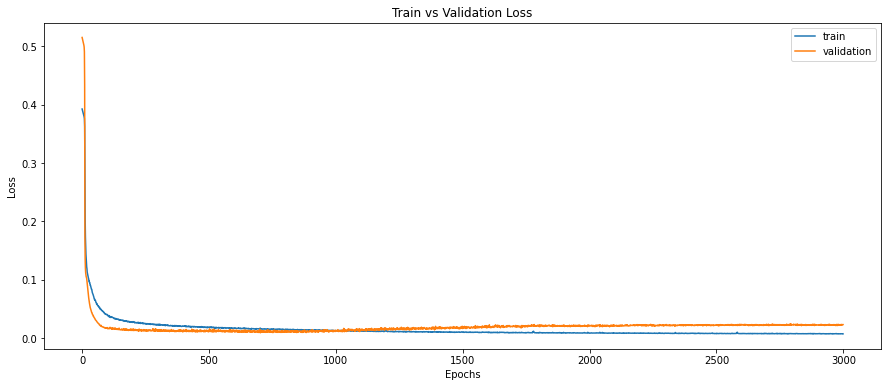

In [29]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
# SAVE AND LOAD MODEL
# model.save("model2.h5")

# load model
# model = load_model('model2.h5')

In [31]:
# prediction
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = X_test[0].copy()

# print(X_test[0],X_test.shape)
# print(X_test_model,X_test_model.shape)

In [32]:
for i in range(X_test.shape[0]):
    
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_months_in,n_features)
#     print("Before\n")
#     print(X_test_model)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_months_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("y_pred all")
#     print(y_pred[i])
#     print("y_test all")
#     print(y_test[i])
    pred=pred.reshape(n_months_out,n_features)
#     print(pred)
    if(n_months_out>n_months_in):
        X_test_model[0,:] = pred[-n_months_in:]
    else:
        X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
        X_test_model[0,-n_months_out:] = pred

#     X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
#     X_test_model[0,-n_months_out:] = pred[-n_months_in:]
#     print("After")
#     print(X_test_model)
    


In [33]:
# y_pred = y_pred.reshape(y_test.shape[0],n_months_out*n_features)
# print(y_pred.shape)
y_pred_inv = np.zeros_like(y_pred)
y_test_inv = np.zeros_like(y_test)
for i in range(1,n_months_out+1):
#     print(i)
    y_pred_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred[:,(i-1)*n_features:i*n_features])
#     print(scaler.inverse_transform(y_pred[0:3,(i-1)*n_features:i*n_features]))
#     print("--------------------------------------------------------- i= ",i)
#     print(y_pred_inv[0:3,:])
#     print("--------------------------------------------------------- test")
    
    
    y_test_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_test[:,(i-1)*n_features:i*n_features])
#     print(y_test_inv[0:10,:])
rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

Test RMSE: 36.929 


In [34]:
y_test_re = y_test_inv.reshape(n_months_out*y_test_inv.shape[0], n_features)
y_pred_re = y_pred_inv.reshape(n_months_out*y_pred_inv.shape[0], n_features)
print(y_pred_re.shape)
print(y_test_re.shape)
rmse = mean_squared_error(y_test_re, y_pred_re) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

(899, 6)
(899, 6)
Test RMSE: 36.929 


In [35]:
# print(y_pred_re[:10,])
# print(y_test_re[:10,])

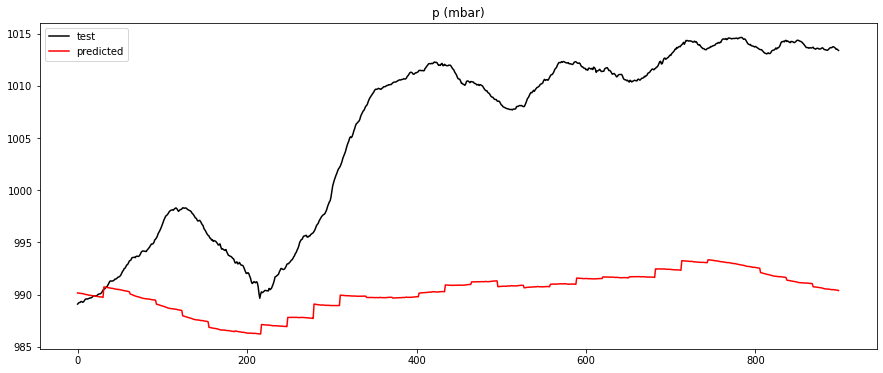

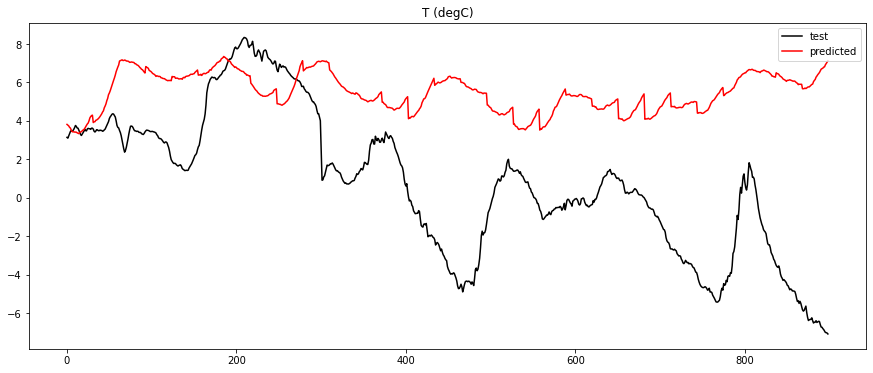

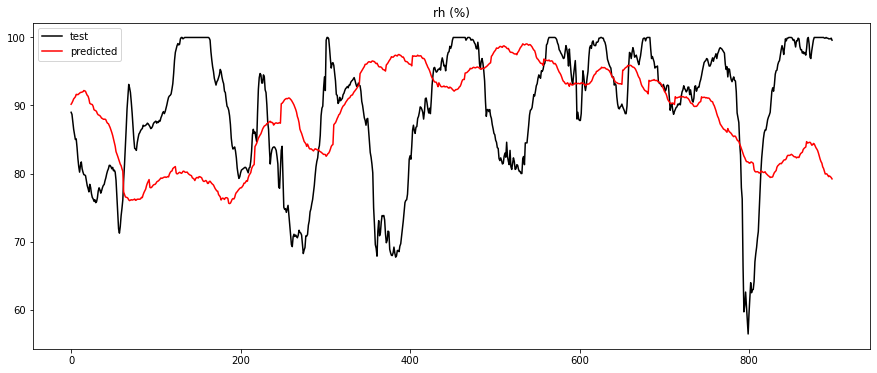

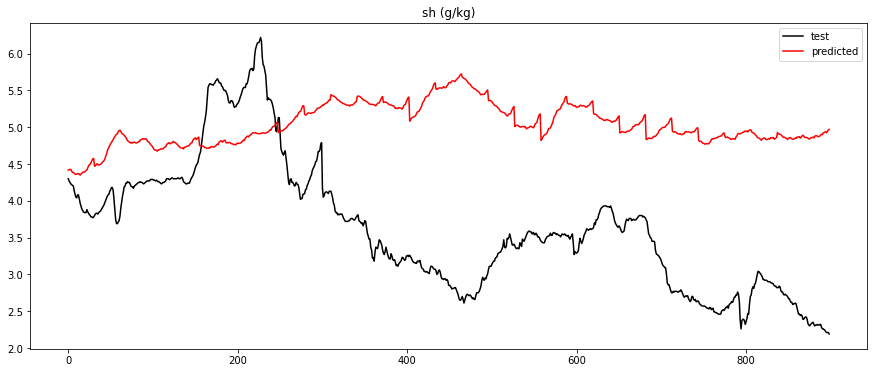

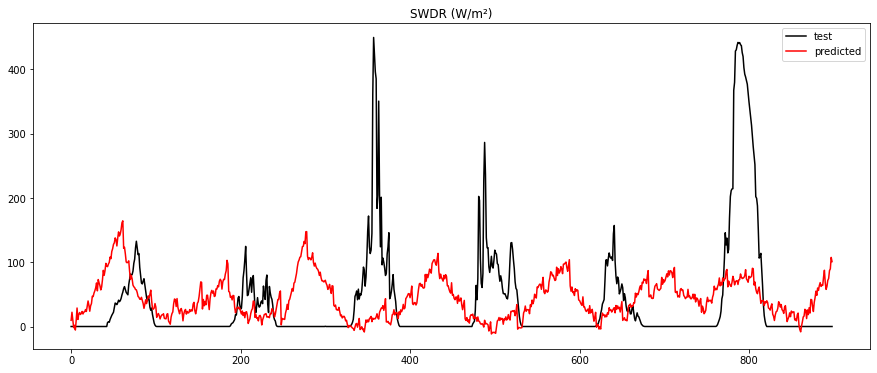

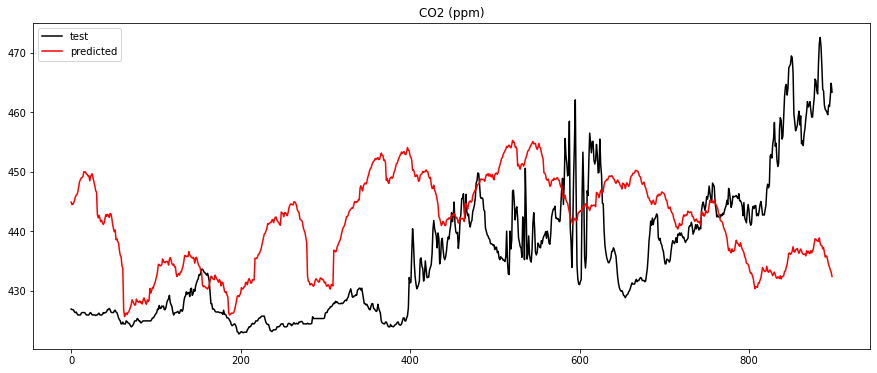

In [36]:
for i in range(n_features):
    plt.plot(y_test_re[:,i],color='black')
    plt.plot(y_pred_re[:,i],color='red')
    plt.legend(["test","predicted"])
    plt.title(col_names[i])
    plt.show()
